In [1]:
import pandas as pd
import cv2 as cv

In [2]:
import idx2numpy
import numpy as np

images_train = idx2numpy.convert_from_file('train-images-idx3-ubyte')
labels_train =idx2numpy.convert_from_file('train-labels.idx1-ubyte')
images_test = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')
labels_test = idx2numpy.convert_from_file('t10k-labels-idx1-ubyte')

In [3]:
def vectorized_result(j):
    e = np.zeros((10,1))
    e[j] = 1.0
    return e

In [4]:
def GaussianBlurGrisLvlReduct(image):
    image = cv.GaussianBlur(image.reshape(28,28),(7,7),0.2).astype(np.uint8)
    image = np.reshape(np.round(image*(3/255))*(255/3),(784,1))
    return image

In [5]:
training_inputs=[GaussianBlurGrisLvlReduct(image) for image in images_train]
training_results =[vectorized_result(label) for label in labels_train]
test_inputs = [GaussianBlurGrisLvlReduct(image) for image in images_test]
test_results = [int(label) for label in labels_test]

In [6]:
train_data =list(zip(training_inputs,training_results))
test_data = list(zip(test_inputs,test_results))

In [164]:
# test_inputs=[np.reshape(row[1:].ravel(),(784,1)) for index, row in df_test.iterrows()]

In [165]:
# test_results = [row[0] for index, row in df_test.iterrows()]

In [173]:
# training = list(zip(training_inputs, training_results)) #il faut trransformer en list après avoir zipper le tout
# test = list(zip(test_inputs, test_results))

In [153]:
# training = []
# for index, row in df.iterrows():
#   training.append((np.reshape(row[1:].ravel(),(784,1)), vectorized_result(row[0])))


In [154]:
# test=[]
# for index, row in df_test.iterrows():
#   test.append((np.reshape(row[1:].ravel(),(784,1)),row[0]))

In [122]:
import numpy as np

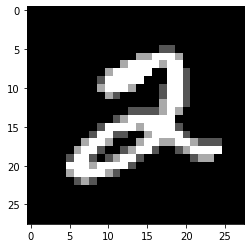

In [123]:
import matplotlib.pyplot as plt

plt.imshow(training_inputs[5].reshape(28,28), cmap='gray')

In [13]:
import random

class Network (object):

  def __init__(self, sizes):
    self.num_layers = len(sizes)
    self.sizes= sizes 
    self.biases = [np.random.randn(y,1) for y in sizes[1:] ]
    self.weights = [np.random.randn(y,x) for x,y in zip(sizes[:-1],sizes[1:]) ]

  def sigmoid(self, z):
    return 1.0/(1.0+np.exp(-z))
  
  
  def sigmoid_prime(self, z):
    """Derivative of the sigmoid function."""
    return self.sigmoid(z)*(1-self.sigmoid(z)) 
  
  #a′=σ(wa+b) feedforward activation function
  def feedforward(self, a):
    #this is a loop which allows to propagate our input "a" through the network, so that each output 
    #is considered as an input of the next bridge (connexion of two layers)
    for w,b in zip(self.weights, self.biases) :  # going through the network by iterating the bridges
      a = self.sigmoid(np.dot(w,a)+b)
    return a   # we return the final result of our propagation (the prediction)

  def update_mini_batch(self,mini_batch, mu) :
    nabla_b = [np.zeros(b.shape) for b in self.biases] #initialisation of the cost gradient matrix of biaises
    nabla_w = [np.zeros(w.shape) for w in self.weights] # initialisation of the cost gradient matrix of weights
    #for each individual in our mini_batch we are calculating the gradient of each individual cost then add it to the total gradient 
    #of the batch (nabla_w or nabla_b) 
    for x,y in mini_batch : 
      delta_nabla_b, delta_nabla_w = self.backprop(x,y)
      nabla_b = [nb+dnb for nb, dnb in zip(nabla_b,delta_nabla_b)]
      nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    self.weights = [ w-(mu/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
    self.biases = [ b-(mu/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]
    
  def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            self.sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

  def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

  def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

  def SGD(self, data_training, epochs, mini_batch_size, mu , test_data=None) :
    #the training data is a list of tuples (x,y)
    if(test_data) : n_test=len(test_data) 
    n= len(data_training)
    for j in range(epochs) :
      random.shuffle(data_training)
      #dividing the hole training data into mani batches for one epoch
      mini_batches = [ data_training[k:k+mini_batch_size] for  k in range(0,n,mini_batch_size)]

      #strat of an apoch
      for mini_batch in mini_batches :
        self.update_mini_batch(mini_batch, mu)
      #end of an epoch 

      if test_data : 
        print("Epoch {0}: {1} / {2}".format(j,self.evaluate(test_data),n_test))
      else :
        print("Epoch {0} complete".format(j))

    



In [135]:
import random

# Third-party libraries
import numpy as np

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [153]:
net = Network([784,30,10])

In [154]:
net.SGD(train_data, 30 ,10, 1, test_data=test_data)

<ipython-input-140-04fab635e91b>:12: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


Epoch 0: 2607 / 10000
Epoch 1: 4197 / 10000
Epoch 2: 4078 / 10000
Epoch 3: 3059 / 10000
Epoch 4: 2228 / 10000
Epoch 5: 2939 / 10000
Epoch 6: 2881 / 10000
Epoch 7: 2632 / 10000
Epoch 8: 2587 / 10000
Epoch 9: 3210 / 10000
Epoch 10: 3410 / 10000
Epoch 11: 3043 / 10000
Epoch 12: 3503 / 10000
Epoch 13: 3111 / 10000
Epoch 14: 3113 / 10000
Epoch 15: 3560 / 10000
Epoch 16: 3359 / 10000
Epoch 17: 3260 / 10000
Epoch 18: 4383 / 10000
Epoch 19: 4316 / 10000
Epoch 20: 2635 / 10000
Epoch 21: 3651 / 10000
Epoch 22: 2691 / 10000
Epoch 23: 3033 / 10000
Epoch 24: 3751 / 10000
Epoch 25: 3668 / 10000
Epoch 26: 3647 / 10000
Epoch 27: 3499 / 10000
Epoch 28: 2985 / 10000
Epoch 29: 2921 / 10000


In [ ]:
from sklearn import svm

model = svm.SVC()
model.fit(np.reshape(training_inputs,(60000,784)),labels_train)


In [ ]:
import cv2 as cv
img=cv.imread("neuf.png")
img=cv.cvtColor(img, cv.COLOR_BGR2GRAY)
resized = np.array(cv.resize(img,[28,28],interpolation=cv.INTER_AREA))
cv.imshow(resized)

In [15]:
test= np.reshape(test_inputs,(10000,784))
predictions =model.predict(test)

In [16]:

predictions=[int(value) for value in predictions]
res = [int(value) for value in test_results]
correct= sum(int(x==y) for x,y in zip(res,predictions))

print("correct predictions : {0}/{1} ".format(correct,len(res)))

correct predictions : 9782/10000 


In [18]:
import pickle

with open('model_pkl', 'wb') as files:
    pickle.dump(model, files)